# Training the CNN with CIFAR-10 and defend it

This notebook trains a CNN like ResNet-18 or LeNet5 with the CIFAR-10 dataset in a deterministic fashion and stores the obtained weights.

### 0. Import libraries and define settings

In [1]:
# import Python packages
import os
import time
import random
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

# import custom Python modules
import utils
from data_loader import DataLoader
from resnet_architecture import ResNet
from lenet_architecture import Net

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2

sns.set()



In [2]:
# get cuda or cpu device for training
device = utils.get_device()


Currently using: cuda


In [3]:
# make PyTorch deterministic
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


In [4]:
# define paths and model name
MODEL_PATH = "model/"
MODEL_NAME = "defended_lenet5_100_epochs"


### 1. Load and preprocess data

In [5]:
data_loader = DataLoader()
trainset, trainloader = data_loader.load_train_data()
testset, testloader = data_loader.load_test_data()


Files already downloaded and verified
Files already downloaded and verified


### 2. Visualize performance

In [6]:
def plot_accuracy(train_acc, test_acc, lambda_value):
    plt.plot(range(len(train_acc)), train_acc, color=(0.48942421, 0.72854938, 0.56751036))
    plt.plot(range(len(test_acc)), test_acc, color=(0.14573579, 0.29354139, 0.49847009))
    plt.legend(["train", "test"])
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title(f"Train and test accuracy evolution\nregularization strength {lambda_value}")

    print(f"Train accuracy: {train_acc[-1]}\nTest accuracy: {test_acc[-1]}")
    plt.savefig(f"./defended_lenet5_100_epochs_{lambda_value}.png", dpi=300)

    plt.show()

### 3. Store model

In [7]:
def store_model(lambda_value):
    # create a folder for storing the models
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)

    # store the trained model
    torch.save(net.state_dict(), MODEL_PATH + MODEL_NAME + f"_{lambda_value}.pth")


### 4. Train the network and search regularization value

100%|██████████| 100/100 [31:33<00:00, 18.94s/it]


Train accuracy: 0.19186
Test accuracy: 0.1923


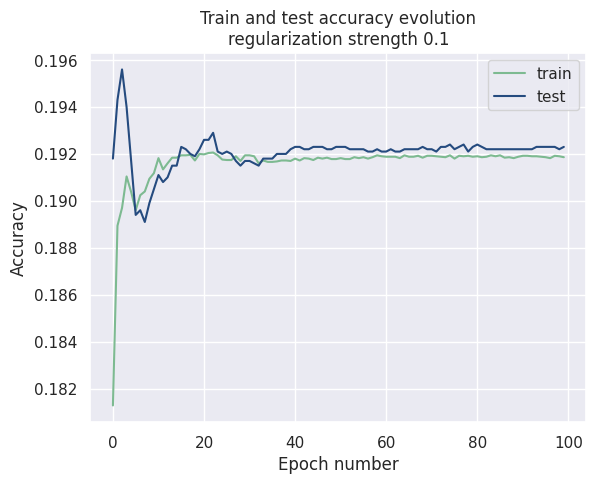

100%|██████████| 100/100 [32:11<00:00, 19.31s/it]


Train accuracy: 0.63228
Test accuracy: 0.6119


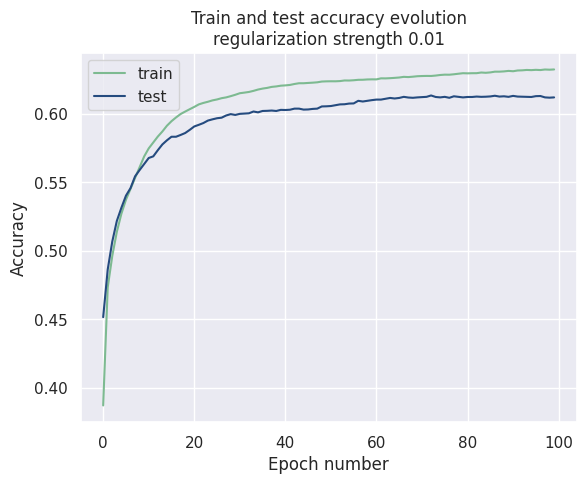

100%|██████████| 100/100 [31:32<00:00, 18.92s/it]


Train accuracy: 0.89852
Test accuracy: 0.5621


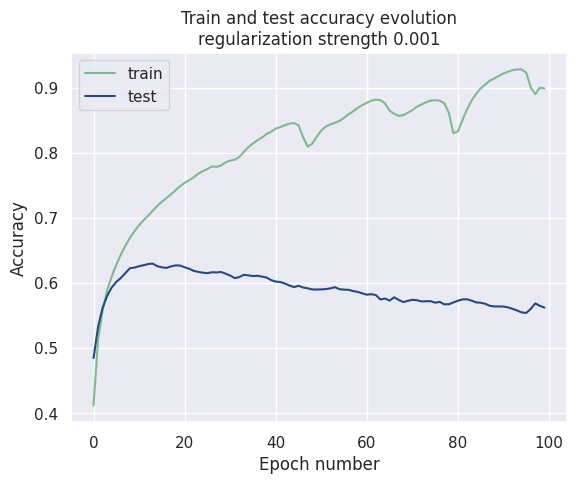

 16%|█▌        | 16/100 [05:05<26:24, 18.86s/it]

In [ ]:
lambda_values = [1e-1, 1e-2, 1e-3]

# experiment with different strength of regularization
for lambda_value in lambda_values:
    # instantiate the network
    net = Net().to(device) #ResNet().to(device)

    # define the loss function
    criterion = nn.CrossEntropyLoss()

    # declare the optimization function
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=lambda_value)

    # initialize the timer
    start = time.time()

    # define lists that store train and test accuracy for each epoch
    train_acc = []
    test_acc = []

    for epoch in tqdm(range(0, 100)):

        # initialize number of correct train predictions for the current epoch
        correct_train_total = 0

        net.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            # Move the data to the device that is used
            x_batch, y_batch = x_batch.to(device), y_batch.to(
                device
            )

            # Set all currenly stored gradients to zero
            optimizer.zero_grad()

            y_pred = net(x_batch)

            # compute loss
            loss = criterion(y_pred, y_batch)

            # backpropagate gradients
            loss.backward()

            # apply the optimization step
            optimizer.step()

            # Get the labels with highest output probability
            y_pred_max = torch.argmax(
                y_pred, dim=1
            )

            # Count how many are equal to the true labels
            correct = torch.sum(
                torch.eq(y_pred_max, y_batch)
            ).item()

            # Keep track of how much time has elapsed
            elapsed = time.time() - start

            # Accumulate number of correct predictions
            correct_train_total += correct

            correct_total = 0

        # store train accuracy for current epoch
        train_acc.append(correct_train_total / len(trainset))

        # Put the network in eval mode
        net.eval()

        for i, (x_batch, y_batch) in enumerate(testloader):
            # Move the data to the device that is used
            x_batch, y_batch = x_batch.to(device), y_batch.to(
                device
            )

            # count number of correct predictions
            y_pred = net(x_batch)
            y_pred_max = torch.argmax(y_pred, dim=1)

            correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        # store test accuracy for current epoch
        test_acc.append(correct_total / len(testset))

    plot_accuracy(train_acc, test_acc, lambda_value)
    store_model(lambda_value)